# MEWpy Community Optimization


Author: Vitor Pereira

License: [CC BY-SA 4.0](http://creativecommons.org/licenses/by-sa/4.0/)

-------

In this tutorial:

- You will learn how to run combinatorial optimization on microbial communities using MEWpy

## Bacterial cross-feeding via extensive gene loss

Metabolic dependencies between microbial species have a significant impact on the
assembly and activity of microbial communities. However, the evolutionary origins of
such dependencies and the impact of metabolic and genomic architecture on their
emergence are not clear.

Recently, [McNally et al.](https://doi.org/10.1186/s12918-018-0588-4) proposed a method to evolve
cooperative interactions among microbial species by fostering cross-feeding of a
diverse set of metabolites. This was achieved by incrementaly deleting genes on
initially two identical bacterias (E. coli) and increasingly imposing constraints on the
community metabolic network such that two new strains evolve and start to diverge
while maximizing the differences on their genotypes.

The aim is to replicate the experiments using
MEWpy to maximize the number of deleted genes on the two strains
while inducing cross-feeding. 

### Run in Google colab

If you are running this notebook in Colab, you need to perform the following steps, otherwise skip.

In [1]:
%%bash
[[ ! -e /colabtools ]] && exit
! pip install -U -q PyDrive

In [2]:
if 'google.colab' in str(get_ipython()):
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    model_file = drive.CreateFile({'id':'1o0XthuEOs28UJ4XTa9SfFSFofazV-2nN'})
    model_file.GetContentFile('e_coli_core.xml.gz')

## Step 1 - Load the model

In [3]:
from cobra.io import read_sbml_model
import warnings
warnings.filterwarnings('ignore')

model = read_sbml_model('models/ec/e_coli_core.xml.gz')

We will make two copies of the model and rename the two strains

In [4]:
from mewpy import get_simulator
wildtype = get_simulator(model)

2026-01-03 16:14:37,167	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [5]:
ec1 = wildtype.copy()
ec1.id = 'ec1'
ec2 =wildtype.copy()
ec2.id = 'ec2'

In the experiment, we will use the medium defined in the model

In [6]:
from mewpy.simulation import Environment
medium = Environment.from_model(wildtype)
medium

,lb,ub
EX_ac_e,0.0,1000.0
EX_acald_e,0.0,1000.0
EX_akg_e,0.0,1000.0
EX_co2_e,-1000.0,1000.0
EX_etoh_e,0.0,1000.0
EX_for_e,0.0,1000.0
EX_fru_e,0.0,1000.0
EX_fum_e,0.0,1000.0
EX_glc__D_e,-10.0,1000.0
EX_gln__L_e,0.0,1000.0


## Step 2 - Find single strain gene KOs

Two make the search for combinatorial gene deletion on the community model, we will first idenfify combinatorial gene delerions in one strain, and use these results to seed the community gene deletions.

We start by defining a gene deletion optimization problem (`GKOProblem`) defining as objective the maximization of biomass production (f1) and the maximization of the number of deletions.

In [7]:
from mewpy.problems import GKOProblem
from mewpy.optimization.evaluation import TargetFlux, CandidateSize

In [8]:
f1 = TargetFlux(wildtype.biomass_reaction,method='FBA')
f2 = CandidateSize(maximize=True)

To simpilfy the problem, we will define a maximum of 30 gene deletion and run 10 optimization iterations.

In [9]:
problem = GKOProblem(wildtype,
                     [f1,f2],
                     candidate_max_size = 50)


In [10]:
from mewpy.optimization import EA
ea = EA(problem, max_generations=50)
gkos = ea.run(simplify=False)

[2026-01-03 16:14:37] [mewpy.problems.genes] [INFO] Building modification target list.
100%|██████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 2088.71it/s]
2026-01-03 16:14:40,726	INFO worker.py:2007 -- Started a local Ray instance.
[2026-01-03 16:14:42] [mewpy.util.process] [INFO] Using 4 workers.
[2026-01-03 16:14:42] [mewpy.optimization.jmetal.ea] [INFO] Running NSGAII
[2026-01-03 16:14:42,707] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-03 16:14:42,711] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
(RayActor pid=72579) /Users/vpereira/miniconda3/envs/mewpy/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
(RayActor pid=72579)   warn(f"Solver status is '{status}'.", UserWarning)
[2026-01-03 16:14:45,099] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-03 16:14:45] [mewpy] [INFO] Eval(s)|     Worst      Best    Median   Average   Std De

We can have a look to the solution found by the evolutionary algoritm (EA)

In [11]:
ea.dataframe()

,Modification,Size,TargetFlux,Size
0,"{'b0733': 0, 'b1276': 0, 'b2463': 0, 'b0724': ...",50,0.000000,50.0
1,"{'b0810': 0, 'b4014': 0, 'b1676': 0, 'b1478': ...",23,0.873922,23.0
2,"{'b0733': 0, 'b4014': 0, 'b2463': 0, 'b0724': ...",50,0.000000,50.0
3,"{'b0810': 0, 'b4014': 0, 'b0721': 0, 'b1101': ...",43,0.211663,43.0
4,"{'b0810': 0, 'b4152': 0, 'b0721': 0, 'b1101': ...",33,0.680085,33.0
...,...,...,...,...
73,"{'b0733': 0, 'b4151': 0, 'b0724': 0, 'b0116': ...",50,0.000000,50.0
74,"{'b1276': 0, 'b1101': 0, 'b2463': 0, 'b0724': ...",50,0.000000,50.0
75,"{'b0733': 0, 'b1276': 0, 'b0721': 0, 'b2463': ...",50,0.000000,50.0
76,"{'b0733': 0, 'b2463': 0, 'b0724': 0, 'b4154': ...",50,0.000000,50.0


and run an FBA on the first solution (the biomass is set by default as objective)

In [12]:
problem.simulate(solution=gkos[0].values)

============================================================
Simulation Result
============================================================
Status:              INFEASIBLE
Objective (maximize): 3.3917
Method:              FBA
Model:               e_coli_core
Fluxes:              44 non-zero / 95 total
Constraints:         22
  Simulation:        22
Shadow prices:       72 available
============================================================

We may now generate solutions that will seed the EA to be used later in the community gene deletions.

In [13]:
import random

init_pop = []
for s in gkos:
    x=s.values
    init_pop.append([k+'_ec1' for k in x.keys()])
    init_pop.append([k+'_ec2' for k in x.keys()])

random.shuffle(init_pop)


## Community mutants 

We can now address our main goal, starting by defining a community model. We will not impose a relative abundance (`merge_biomasses=False`), instead we will include in the optimization task the secondary implicit goal of "minimizing the difference between the mutant growth" using a regularized FBA.  

In [14]:
from mewpy.model import CommunityModel
from mewpy.com import regComFBA

community= CommunityModel([ec1,ec2],merge_biomasses=False,flavor='cobra')
sim = community.get_community_model()
sim.set_environmental_conditions(medium)

Organism: 100%|██████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.57it/s]


We will consider 3 optimization objectives:

- Maximize `ec1` growth while ensuring that `ec2` growth is above 0.1/h;
- Maximize `ec2` growth while ensuring that `ec1` growth is above 0.1/h;
- Maximize the total number of gene deletions.

We will be using a Regularized Community FBA (regComFBA) to select a specific solution.

In [15]:
f1 = TargetFlux(community.organisms_biomass['ec1'],
                community.organisms_biomass['ec2'],
                min_biomass_value=0.1,method=regComFBA)

f2 = TargetFlux(community.organisms_biomass['ec2'],
                community.organisms_biomass['ec1'],
                min_biomass_value=0.1,method=regComFBA)

f3 = CandidateSize(maximize=True)

In [16]:
problem = GKOProblem(sim,
                     [f1,f2,f3],
                     candidate_max_size = 60)

Now that we have defined the optimization problem, we may run it (for 10 iterations, and considering a maximum of 60 gene deletions in total)

In [17]:
from mewpy.util.constants import EAConstants
EAConstants.DEBUG = True

ea = EA(problem,
        max_generations=10,
        initial_population=init_pop[:100])

solutions = ea.run(simplify=False)

[2026-01-03 16:14:53] [mewpy.problems.genes] [INFO] Building modification target list.
100%|██████████████████████████████████████████████████████████████████| 274/274 [00:00<00:00, 1801.12it/s]
2026-01-03 16:14:53,251	INFO worker.py:1839 -- Calling ray.init() again after it has already been called.
[2026-01-03 16:14:53] [mewpy.util.process] [INFO] Using 4 workers.
[2026-01-03 16:14:53] [mewpy.optimization.jmetal.ea] [INFO] Running NSGAII
[2026-01-03 16:14:53,412] [jmetal.core.algorithm] [DEBUG] Creating initial set of solutions...
[2026-01-03 16:14:53,473] [jmetal.core.algorithm] [DEBUG] Evaluating solutions...
(RayActor pid=72586) /Users/vpereira/miniconda3/envs/mewpy/lib/python3.10/site-packages/cobra/util/solver.py:554: UserWarning: Solver status is 'infeasible'.
(RayActor pid=72586)   warn(f"Solver status is '{status}'.", UserWarning)
[2026-01-03 16:14:56,262] [jmetal.core.algorithm] [DEBUG] Initializing progress...
[2026-01-03 16:14:56] [mewpy] [INFO] Eval(s)|     Worst      Best

We may now have a look at the solutions as a dataframe or as a plot

In [18]:
df = ea.dataframe()
df

,Modification,Size,TargetFlux,TargetFlux,Size
0,"{'b4232_ec2': 0, 'b3739_ec2': 0, 'b3738_ec1': ...",60,0.000000e+00,3.175580e-12,60.0
1,"{'b1761_ec1': 0, 'b1297_ec2': 0, 'b0728_ec1': ...",59,6.467368e-13,0.000000e+00,59.0
2,"{'b1761_ec1': 0, 'b2296_ec1': 0, 'b1723_ec1': ...",38,1.031654e-01,6.982614e-01,38.0
3,"{'b3612_ec2': 0, 'b3916_ec2': 0, 'b4232_ec2': ...",53,7.103231e-01,1.019859e-01,53.0
4,"{'b3916_ec2': 0, 'b3739_ec2': 0, 'b0810_ec1': ...",57,0.000000e+00,7.600796e-02,57.0
...,...,...,...,...,...
58,"{'b3612_ec2': 0, 'b0767_ec2': 0, 'b0722_ec2': ...",34,4.114418e-01,4.114418e-01,34.0
59,"{'b1761_ec1': 0, 'b2296_ec1': 0, 'b0810_ec1': ...",36,4.114418e-01,4.114418e-01,36.0
60,"{'b3612_ec2': 0, 'b0767_ec2': 0, 'b0722_ec2': ...",35,4.114418e-01,4.114418e-01,35.0
61,"{'b3738_ec1': 0, 'b0728_ec1': 0, 'b0810_ec1': ...",47,4.114418e-01,4.114418e-01,47.0


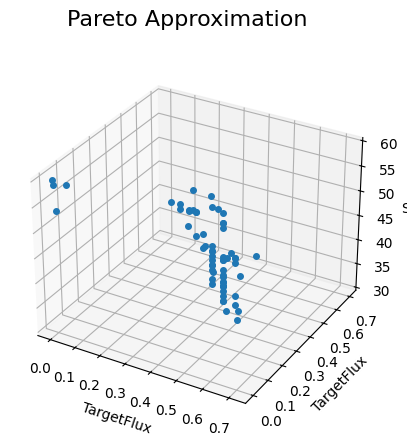

In [19]:
ea.plot()

We may even simulate one of the solution

In [20]:
solution = solutions[5]
solution

[np.float64(0.30607105287393155), np.float64(0.5168125418110134), np.float64(30.0)];{'b1761_ec1': 0, 'b2296_ec1': 0, 'b0810_ec1': 0, 'b3236_ec1': 0, 'b3739_ec1': 0, 'b0008_ec1': 0, 'b4014_ec1': 0, 'b1602_ec1': 0, 'b1478_ec1': 0, 'b0755_ec1': 0, 'b0767_ec1': 0, 'b0721_ec1': 0, 'b0351_ec1': 0, 'b0485_ec1': 0, 'b2976_ec1': 0, 'b3212_ec1': 0, 'b3386_ec1': 0, 'b4122_ec1': 0, 'b3115_ec1': 0, 'b4015_ec1': 0, 'b1101_ec1': 0, 'b4232_ec1': 0, 'b1297_ec1': 0, 'b2463_ec1': 0, 'b0724_ec1': 0, 'b0722_ec1': 0, 'b0733_ec1': 0, 'b1817_ec1': 0, 'b0723_ec1': 0, 'b2284_ec1': 0}

In [21]:
problem.simulate(solution=solution.values,method='FBA').find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.000000
BIOMASS_Ecoli_core_w_GAM_ec2,0.831196
community_growth,0.831196


The previous FBA solution is one of many that result from the genes deletion. We can select one particular solution by considering some additional assumption such as: 
- the organisms will try minimize enzyme ussage (pFBA)
- the difference between the organisms growth is minimized (regComFBA)

**pFBA**

In [22]:
problem.simulate(solution=solution.values,method='pFBA').find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.000000
BIOMASS_Ecoli_core_w_GAM_ec2,0.831196
community_growth,0.831196


**regComFBA**

In [23]:
problem.simulate(solution=solution.values,method=regComFBA).find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.306071
BIOMASS_Ecoli_core_w_GAM_ec2,0.516813
community_growth,0.822884


We may also relax on the community growth to 90% of confidence by setting `obj_frac=0.9` (by default this value is set to 0.99):

In [24]:
problem.simulate(solution=solution.values,method=regComFBA, obj_frac=0.9).find('BIOMASS|growth',show_nulls=True)

,Flux rate
Reaction ID,
BIOMASS_Ecoli_core_w_GAM_ec1,0.374038
BIOMASS_Ecoli_core_w_GAM_ec2,0.374038
community_growth,0.748076


To have a first glimps to the interactions between the organism, we may look at the exchanges with the medium:

In [25]:
from mewpy.com.analysis import exchanges
res = problem.simulate(solution=solution.values,method=regComFBA)
exchanges(community,res)

,ec1,ec2,Total
Metabolite,,,
glc__D_e,-6.327256e+00,-3.672744e+00,-10.00000
gln__L_e,-0.000000e+00,0.000000e+00,0.00000
glu__L_e,-1.590682e+00,1.590682e+00,-0.00000
h2o_e,-2.126751e+01,5.224350e+01,30.97599
h_e,3.199906e+01,-1.549201e+01,16.50705
lac__D_e,1.489496e+01,-1.489496e+01,0.00000
mal__L_e,-0.000000e+00,-0.000000e+00,0.00000
nh4_e,-7.826237e-02,-4.408757e+00,-4.48702
o2_e,-0.000000e+00,-2.403044e+01,-24.03044


Finally, we can audit the deleted reactions: 

In [26]:
problem.solution_to_constraints(solution.values)

{'PGL_ec1': 0,
 'ME2_ec1': 0,
 'ICL_ec1': 0,
 'MALS_ec1': 0,
 'GLUSy_ec1': 0,
 'NADH16_ec1': 0,
 'MDH_ec1': 0,
 'FRUpts2_ec1': 0,
 'SUCDi_ec1': 0,
 'THD2_ec1': 0,
 'GLNabc_ec1': 0,
 'GLUDy_ec1': 0}

## Next Steps:
You may now apply the modifications to the models and analyse further the solution using SMETANA and SteadyCom (see [notebook 8](08-community.ipynb)).

You may also consider running other alternative optimization tasks considering different strategies (e.g. Gene Over/Under Expression) and alternative optimization objectives.